In [129]:
import msgpack as mp
import msgpack_numpy as mpn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *

In [130]:
#data path
_folder_name = "sk13_forward_t0"

_base_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\single_cam_oct_21"
_pth = os.path.join(_base_pth, _folder_name)


In [131]:
#calibration path
_calib_pth = os.path.join(_base_pth, "calibration11")
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#rotation matrix path
_rotmat_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\single_cam_oct_21\calibration11"
_webcam_rotmat_pth = os.path.join(_rotmat_pth, "webcam_rotmat.msgpack")
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")

#timestamp path
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")
_webcam_calib_pth

'C:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\single_cam_oct_21\\calibration11\\webcam_calibration.msgpack'

In [132]:
#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

# open rotation matrix and org
    
with open(_webcam_rotmat_pth, "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)

camera matrix [[854.18206253   0.         346.3795027 ]
 [  0.         864.65874931 268.01454777]
 [  0.           0.           1.        ]]
distortion [[ 1.02169014e-01 -1.48557867e-01 -1.21573114e-03 -2.95257573e-03
  -3.29111851e+00]]


In [133]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)


returning dataframe


In [134]:
#reading mocap df
_mocap_pth = os.path.join(_base_pth, "sk13",_folder_name + ".csv")
_m_df, st_time = read_df_csv(_mocap_pth)
#getting center

_m_df["x"] = _m_df["LB_x"] + _m_df["RB_x"] + _m_df["LT_x"] + _m_df["RT_x"]
_m_df["y"] = _m_df["LB_y"] + _m_df["RB_y"] + _m_df["LT_y"] + _m_df["RT_y"]
_m_df["z"] = _m_df["LB_z"] + _m_df["RB_z"] + _m_df["LT_z"] + _m_df["RT_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

# _m_df["x"] = _m_df["LT_x"] + _m_df["RT_x"]
# _m_df["y"] = _m_df["LT_y"] + _m_df["RT_y"]
# _m_df["z"] = _m_df["LT_z"] + _m_df["RT_z"]

# _m_df["x"] = _m_df["x"] / 2
# _m_df["y"] = _m_df["y"] / 2
# _m_df["z"] = _m_df["z"] / 2

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

In [135]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [136]:
offset = np.array([-0.157, -0.005, -0.28])
# offset = np.array([0, 0, 0])

In [137]:

w_df = None

w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

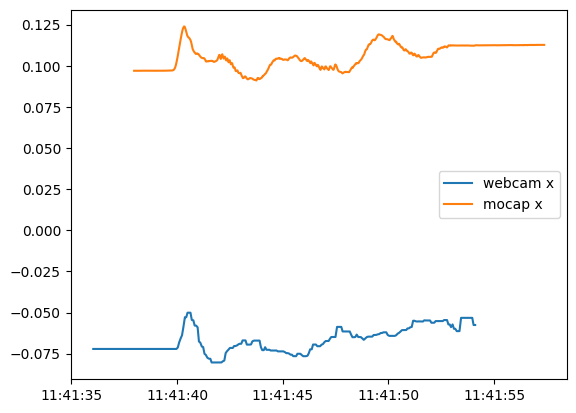

In [138]:

plt.plot(_w_df["time"], w_df["x"].rolling(5).median()+ offset[0], label="webcam x")
# plt.plot(_w_df["time"], w_df["x"], label="webcam x")
plt.plot(_m_df["time"], _m_df["x"], label="mocap x")
plt.legend()

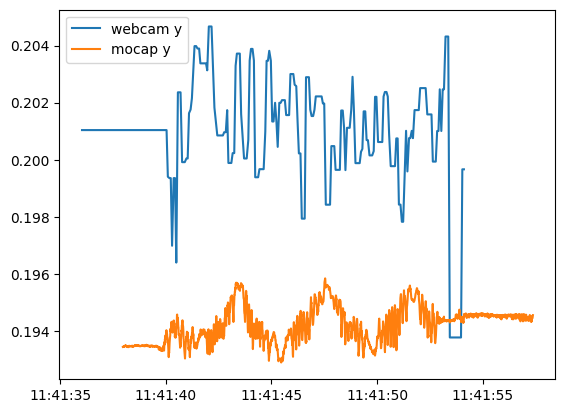

In [139]:

plt.plot(_w_df["time"], w_df["y"].rolling(5).median() + offset[1], label="webcam y")
# plt.plot(_w_df["time"], w_df["y"] + offset[1], label="webcam y")
plt.plot(_m_df["time"], _m_df["y"], label="mocap y")
plt.legend()

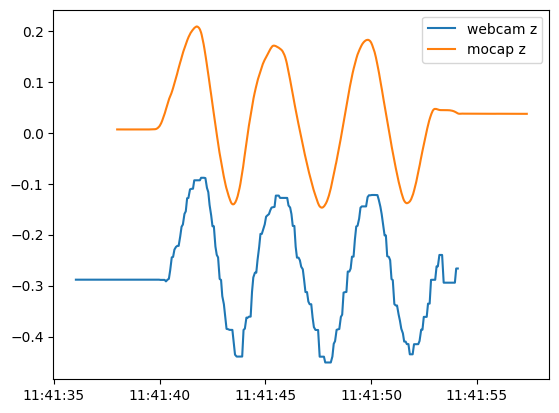

In [140]:

plt.plot(_w_df["time"], w_df["z"].rolling(5).median() + offset[2], label="webcam z")
plt.plot(_m_df["time"], _m_df["z"].rolling(3).median(), label="mocap z")
plt.legend()

In [141]:
radius = 47.5/1000
lx = 79 #half of the distance between the wheels
ly = 122.5/2

In [142]:
_sk_csv_pth = os.path.join(_pth, "imu01.csv")
_sk_df = pd.read_csv(_sk_csv_pth)


In [143]:
_sk_df = set_zero(_sk_df)
_sk_df, _ang_column = get_angular_velocity(_sk_df)
_sk_df, _ = get_directional_velocity(_sk_df, _ang_column, radius, lx, ly)
_sk_df, _ = get_position(_sk_df)


In [144]:
_sk_df["sys_time"] = pd.to_datetime(_sk_df["sys_time"])
_a = 0.085
_b = 0.15

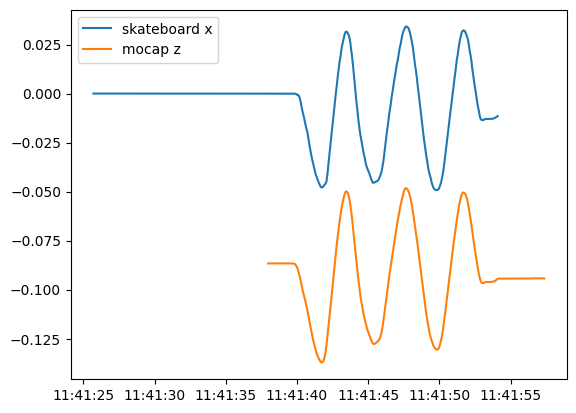

In [145]:
plt.plot(_sk_df["sys_time"],_sk_df["x_val"], label="skateboard x")
plt.plot(_m_df["time"], _m_df["z"]*-0.25 - _a, label="mocap z")
plt.legend()


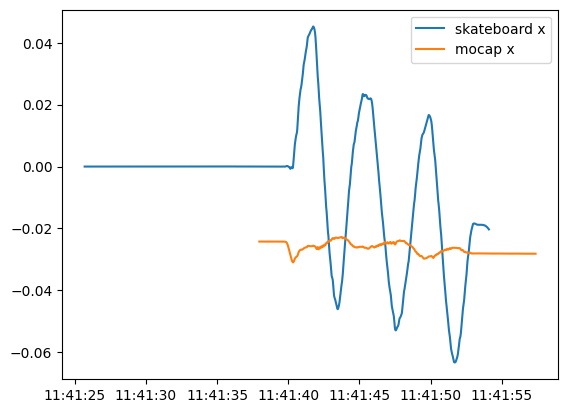

In [146]:
plt.plot(_sk_df["sys_time"],_sk_df["y_val"], label="skateboard x")
plt.plot(_m_df["time"], _m_df["x"]*-0.25, label="mocap x")
plt.legend()


In [147]:
_tt = w_df[["yaw","pitch", "roll"]].iloc[100]
_tt

yaw     -3.064075
pitch    0.006029
roll     0.028852
Name: 100, dtype: float64

In [148]:
w_df

,frame_id,x,y,z,yaw,pitch,roll,time
0,5.0,0.084859,0.206039,-0.008329,-2.979898,0.026989,0.132881,2022-10-21 11:41:35.775340
1,5.0,0.084859,0.206039,-0.008329,-2.979898,0.026989,0.132881,2022-10-21 11:41:35.836174
2,5.0,0.084859,0.206039,-0.008329,-2.979898,0.026989,0.132881,2022-10-21 11:41:35.898941
3,5.0,0.084859,0.206039,-0.008329,-2.979898,0.026989,0.132881,2022-10-21 11:41:35.973440
4,5.0,0.084859,0.206039,-0.008329,-2.979898,0.026989,0.132881,2022-10-21 11:41:36.037442
...,...,...,...,...,...,...,...,...
271,5.0,0.103759,0.198768,-0.014216,3.213203,-0.005754,0.176237,2022-10-21 11:41:53.844262
272,5.0,0.099418,0.204664,0.013593,-3.062369,0.006212,0.032038,2022-10-21 11:41:53.902762
273,5.0,0.099418,0.204664,0.013593,-3.062369,0.006212,0.032038,2022-10-21 11:41:53.967762
274,5.0,0.095668,0.208511,0.035433,-2.937802,0.038080,0.064435,2022-10-21 11:41:54.029763


In [149]:
_temp = cv2.Rodrigues(np.array(_tt))
_temp = np.array(_temp[0])
_x = _temp.T[0]
_y = _temp.T[1]
_z = _temp.T[2]

_temp

array([[ 0.99981522, -0.0046567 , -0.01865058],
       [-0.00320103, -0.99700026,  0.07733192],
       [-0.01895474, -0.07725793, -0.99683094]])

In [150]:
_r0 = w_df[["yaw","pitch", "roll"]].loc[0].values
_rotmat_r0 = cv2.Rodrigues(_r0)[0]
_rotmat_r0

array([[ 0.99589346, -0.02499881, -0.08701313],
       [-0.01092688, -0.98728492,  0.15858465],
       [-0.08987118, -0.15698263, -0.98350375]])

In [151]:
def transform_aruco_to_wheels(df):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        _rot_vec = df[["yaw","pitch", "roll"]].loc[i].values
        _rot_vec = np.array(_rot_vec)
        _rot_mat = cv2.Rodrigues(_rot_vec)[0]
        _rot_mat = np.array(_rot_mat)

        _del_rot_mat = _rotmat_r0.T@_rot_mat
        _xv = _del_rot_mat.T[0]
        _xv = np.reshape(_xv, (3,1))
        _yv = _del_rot_mat.T[1]
        _yv = np.reshape(_yv, (3,1))
        _zv = _del_rot_mat.T[2]
        _zv = np.reshape(_zv, (3,1))

        # translation vector
        _tv = df[["x", "y", "z"]].loc[i].values
        _tv = np.reshape(_tv, (3,1))

        # point in cart pc
        _a = 0.085
        _b = 0.15
        pc = _tv - _a*_zv + _b*_yv
        pc = pc.T[0]
        
        df1["x"].replace({df1["x"].loc[i]: pc[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: pc[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: pc[2]}, inplace=True)
    return df1

In [152]:
test_df = transform_aruco_to_wheels(w_df)

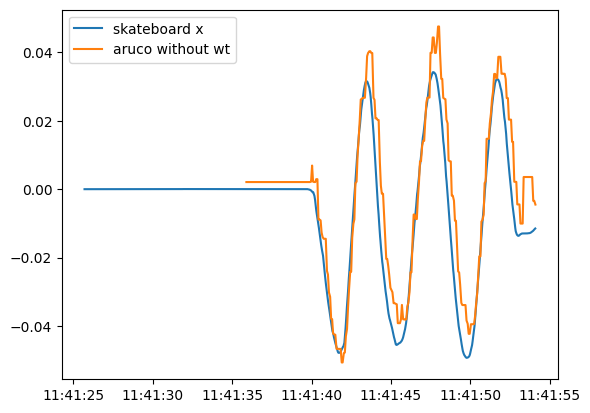

In [155]:
plt.plot(_sk_df["sys_time"],_sk_df["x_val"], label="skateboard x")
plt.plot(test_df["time"], test_df["z"].rolling(3).median()*-0.25, label="aruco x")
plt.plot(w_df["time"], w_df["z"].rolling(3).median()*-0.25, label="aruco without wt")
plt.legend()

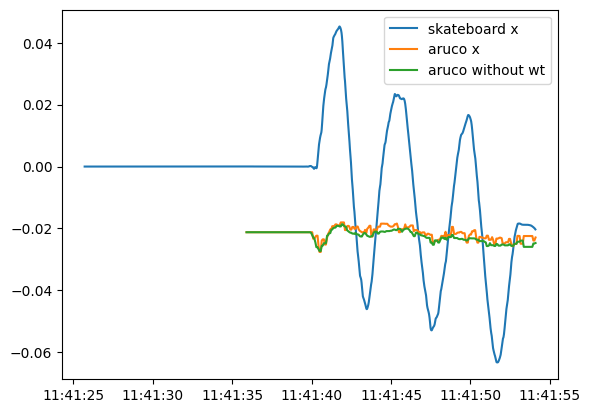

In [154]:
plt.plot(_sk_df["sys_time"],_sk_df["y_val"], label="skateboard x")
plt.plot(test_df["time"], test_df["x"].rolling(3).median()*-0.25 , label="aruco x")
plt.plot(w_df["time"], w_df["x"].rolling(3).median()*-0.25, label="aruco without wt")

plt.legend()